In [ ]:
# ==================== Generate 3D grayscale point cloud ====================

import numpy as np
from PIL import Image
import os


DATA_DIR = "../DATASETS/Cam_Calib_HMK1/tesla"                    
IMG1_NAME = "320.jpg"               
DEPTH_NAME = "320_depth.npy"        
GRAY_PLY = "gray_pointcloud.ply"
SUBSAMPLE = 2

# Load grayscale image and depth map
gray_img = np.array(Image.open(os.path.join(DATA_DIR, IMG1_NAME)).convert("L"))
depth = np.load(os.path.join(DATA_DIR, DEPTH_NAME))

# Build camera intrinsic matrix (K1)
h, w = depth.shape
fx = 1180.0
fy = 1180.0
cx, cy = w / 2.0, h / 2.0
K1 = np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]], float)

print("K1:")
print(K1)

# Generate subsampled pixel grid
us = np.arange(0, w, SUBSAMPLE)
vs = np.arange(0, h, SUBSAMPLE)
uu, vv = np.meshgrid(us, vs)
uu = uu.ravel()
vv = vv.ravel()

# Get corresponding depth values
zz = depth[vv, uu].ravel()

# Keep only pixels with valid depth
mask = zz > 0
uu_valid = uu[mask].astype(float)
vv_valid = vv[mask].astype(float)
zz_valid = zz[mask].astype(float)

# Back-project to 3D using intrinsic parameters
xx = (uu_valid - cx) * zz_valid / fx
yy = (vv_valid - cy) * zz_valid / fy
pts_3d = np.stack([xx, yy, zz_valid], axis=1)

# Extract grayscale values for each 3D point
grays = gray_img[vv[mask], uu[mask]].ravel()

# Save grayscale point cloud in PLY format
with open(GRAY_PLY, "w") as f:
    f.write(
        f"ply\nformat ascii 1.0\nelement vertex {len(pts_3d)}\n"
        f"property float x\nproperty float y\nproperty float z\n"
        f"property uchar red\nproperty uchar green\nproperty uchar blue\nend_header\n"
    )
    for (x, y, z), gray in zip(pts_3d, grays):
        f.write(f"{x} {y} {z} {int(gray)} {int(gray)} {int(gray)}\n")


K1:
[[1.18e+03 0.00e+00 6.40e+02]
 [0.00e+00 1.18e+03 4.45e+02]
 [0.00e+00 0.00e+00 1.00e+00]]


In [ ]:
# ============================================================
# This script computes the intrinsic matrix K2 for the 2nd image,
# reconstructs corresponding 3D points from image 1 using its depth map,
# estimates the camera extrinsic parameters (R, T) for image 2 using SVD,
# and finally constructs the projection matrix P2 = K2 [R | t].
# ============================================================


IMG2_NAME = "330.jpg"
MATCHES_NAME = "320_330_matches.npy"

# Read color image and matched keypoints
color_img = np.array(Image.open(os.path.join(DATA_DIR, IMG2_NAME)).convert("RGB"))
matches = np.load(os.path.join(DATA_DIR, MATCHES_NAME))

# pts1 = matched points in image 1, pts2 = matched points in image 2
pts1 = matches[:, :, 0]
pts2 = matches[:, :, 1]

# Get image size of the RGB image
h2, w2, _ = color_img.shape

# Construct K2 using the same focal length as K1,
# but recompute the principal point (cx2, cy2) from the new image size
fx = 1180.0
fy = 1180.0
cx2 = w2 / 2.0
cy2 = h2 / 2.0
K2 = np.array([[fx, 0, cx2], [0, fy, cy2], [0, 0, 1]], float)

print("K2:")
print(K2)

# Filter valid depth pixels from image 1
u1, v1 = pts1[:, 0], pts1[:, 1]
u1i = np.clip(np.round(u1).astype(int), 0, w - 1)
v1i = np.clip(np.round(v1).astype(int), 0, h - 1)

# Extract depth from image 1
z1 = depth[v1i, u1i]

# Keep only points with valid depth
mask = z1 > 0
u1_valid, v1_valid, z1_valid = u1[mask], v1[mask], z1[mask]
pts2_valid = pts2[mask]

# Compute 3D points corresponding to matched points in image 1
X = (u1_valid - K1[0, 2]) * z1_valid / K1[0, 0]
Y = (v1_valid - K1[1, 2]) * z1_valid / K1[1, 1]
Z = z1_valid
pts3d_corr = np.stack([X, Y, Z], axis=1)

# Convert pts2 to normalized camera coordinates using K2⁻¹
pts2_norm = np.linalg.inv(K2) @ np.vstack([pts2_valid.T, np.ones(pts2_valid.shape[0])])
pts2_norm = pts2_norm[:2].T  # keep only x, y normalized coordinates

# Solve for [R | t] using linear least squares (homogeneous linear system)
n = pts3d_corr.shape[0]
Xh = np.hstack([pts3d_corr, np.ones((n, 1))])
rows = []

# Build the linear system A * m = 0
for i in range(n):
    X_i = Xh[i]
    u_norm, v_norm = pts2_norm[i]
    # Each correspondence contributes two equations
    rows.append(np.hstack([X_i, np.zeros(4), -u_norm * X_i]))
    rows.append(np.hstack([np.zeros(4), X_i, -v_norm * X_i]))

A = np.vstack(rows)

# Solve using SVD; the last column of V gives the solution
_, _, Vt = np.linalg.svd(A)
M = Vt[-1].reshape(3, 4)

# Extract R and t from the estimated matrix
R = M[:, :3]
t = M[:, 3]

# Enforce proper rotation matrix using orthogonalization
U, S, Vt = np.linalg.svd(R)
R = U @ Vt

# If determinant is negative, flip sign
if np.linalg.det(R) < 0:
    R = -R
    t = -t

# Build projection matrix P2 = K2 [R | t]
P2 = K2 @ np.hstack([R, t.reshape(3, 1)])

print("\n R:")
print(R)
print("\n t:")
print(t)
print("\n P2:")
print(P2)


K2:
[[1.18e+03 0.00e+00 6.40e+02]
 [0.00e+00 1.18e+03 4.45e+02]
 [0.00e+00 0.00e+00 1.00e+00]]

 R:
[[ 0.99805441 -0.00179964 -0.06232292]
 [ 0.00132972  0.99997038 -0.00758076]
 [ 0.06233471  0.00748314  0.99802725]]

 t:
[-0.027902   -0.00617595 -0.48966905]

 P2:
[[ 1.21759843e+03  2.66563931e+00  5.65196395e+02 -3.46312555e+02]
 [ 2.93080116e+01  1.18329505e+03  4.35176826e+02 -2.25190346e+02]
 [ 6.23347142e-02  7.48314125e-03  9.98027247e-01 -4.89669046e-01]]


In [ ]:
# ==================== Coloring grayscale point clouds ====================

COLOR_PLY = "colored_pointcloud.ply"

# Project 3D points onto the RGB image using projection matrix P2
n_points = pts_3d.shape[0]
Xh = np.hstack([pts_3d, np.ones((n_points, 1))])  # convert to homogeneous coordinates
xh = (P2 @ Xh.T).T                                 # project: x = P2 * X
u = xh[:, 0] / xh[:, 2]                            # normalized pixel x
v = xh[:, 1] / xh[:, 2]                            # normalized pixel y

# Image size of the RGB image
h2, w2, _ = color_img.shape

# Keep only points whose projections fall inside the image boundaries
inside = (u >= 0) & (u < w2 - 1) & (v >= 0) & (v < h2 - 1)

# Extract visible 3D points and corresponding RGB pixels
visible_points = pts_3d[inside]
u_visible = u[inside].astype(int)
v_visible = v[inside].astype(int)
colors = color_img[v_visible, u_visible, :].reshape(-1, 3)

# Save the colored point cloud in PLY format
with open(COLOR_PLY, "w") as f:
    f.write(
        f"ply\nformat ascii 1.0\nelement vertex {len(visible_points)}\n"
        f"property float x\nproperty float y\nproperty float z\n"
        f"property uchar red\nproperty uchar green\nproperty uchar blue\nend_header\n"
    )
    for (x, y, z), (r, g, b) in zip(visible_points, colors):
        f.write(f"{x} {y} {z} {int(r)} {int(g)} {int(b)}\n")


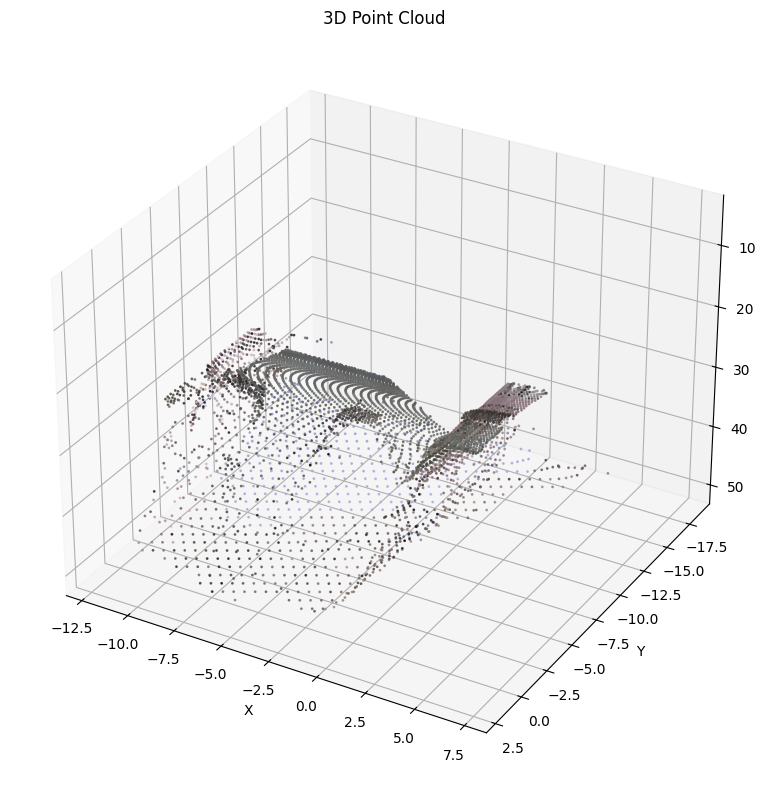

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

# Simple subsampling for visualization
sample_points = visible_points[::50]
sample_colors = colors[::50] / 255.0  # normalize RGB to [0,1]

# Create figure
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the point cloud
ax.scatter(sample_points[:, 0], sample_points[:, 1], sample_points[:, 2],
           s=1, c=sample_colors, alpha=0.8)

# Set title and axes labels
ax.set_title("3D Point Cloud")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

# Invert axes for a more natural camera-like orientation
ax.invert_yaxis()
ax.invert_zaxis()

# Display the figure
plt.tight_layout()
plt.show()
